   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.3 MB/s eta 0:00:00
Device: cuda


100%|██████████| 206M/206M [05:29<00:00, 625kB/s]
Epoch 1/10: 100%|██████████| 704/704 [00:13<00:00, 53.27it/s, D=1.45, G=2.67]


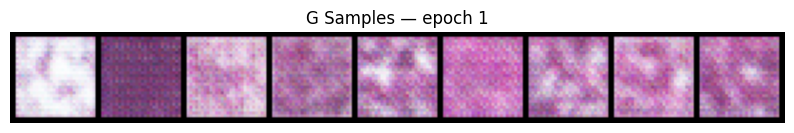

Epoch 2/10: 100%|██████████| 704/704 [00:11<00:00, 62.19it/s, D=0.253, G=0.442]


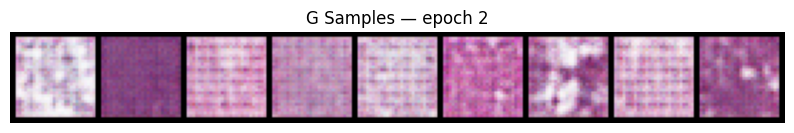

Epoch 3/10: 100%|██████████| 704/704 [00:11<00:00, 61.91it/s, D=0.441, G=1.89]


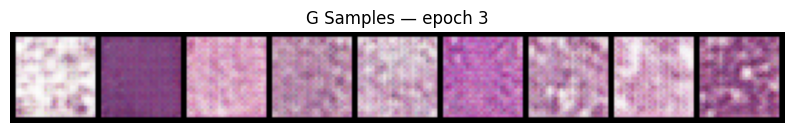

Epoch 4/10: 100%|██████████| 704/704 [00:11<00:00, 61.26it/s, D=1.12, G=1.58]


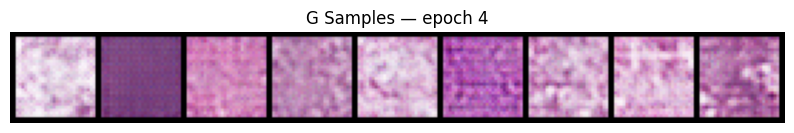

Epoch 5/10: 100%|██████████| 704/704 [00:11<00:00, 61.05it/s, D=0.255, G=1.96]


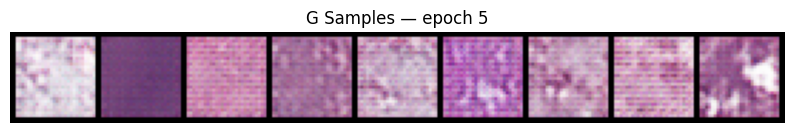

Epoch 6/10: 100%|██████████| 704/704 [00:11<00:00, 61.20it/s, D=0.809, G=4.95]


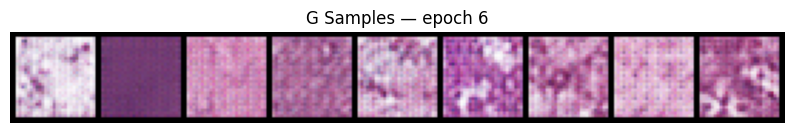

Epoch 7/10: 100%|██████████| 704/704 [00:11<00:00, 60.60it/s, D=1.24, G=2.78]


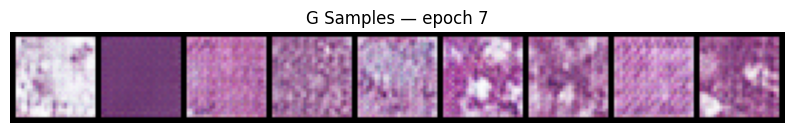

Epoch 8/10: 100%|██████████| 704/704 [00:11<00:00, 60.08it/s, D=0.839, G=0.089]


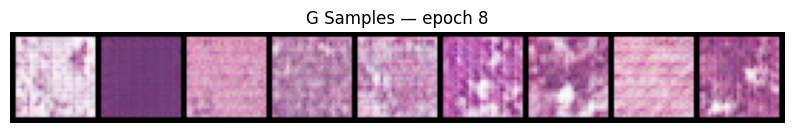

Epoch 9/10: 100%|██████████| 704/704 [00:11<00:00, 60.22it/s, D=0.812, G=5.67]


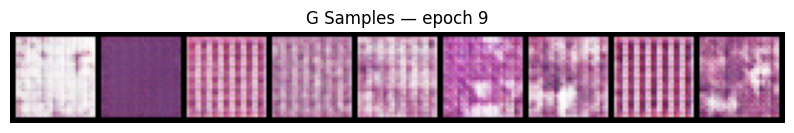

Epoch 10/10: 100%|██████████| 704/704 [00:11<00:00, 59.97it/s, D=0.651, G=4.46]


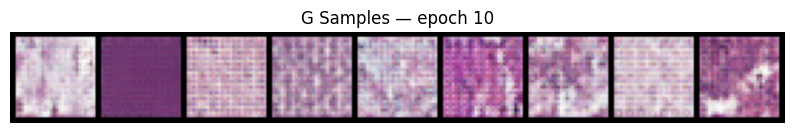

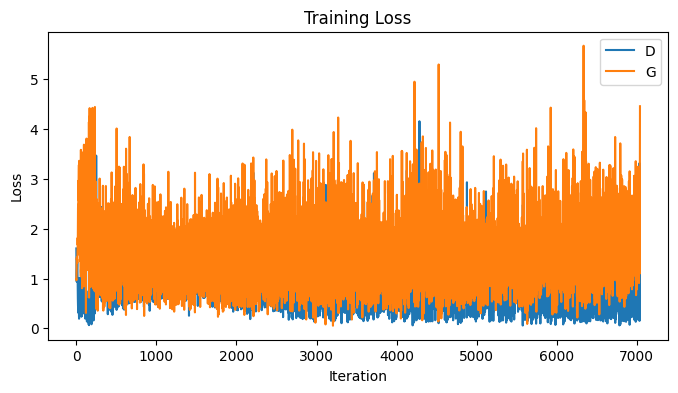

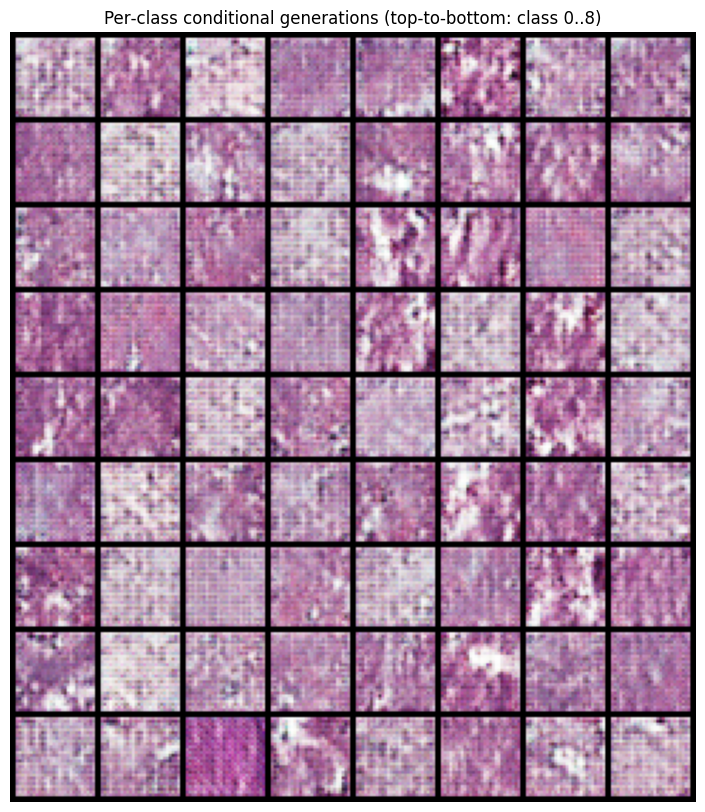

Saved checkpoints to ./checkpoints


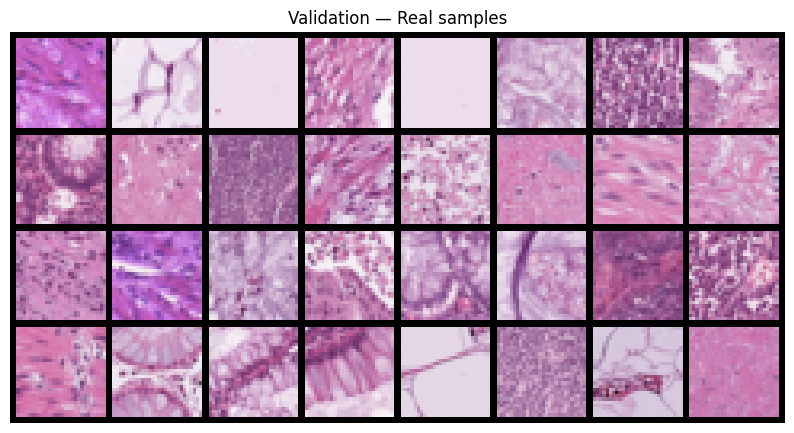

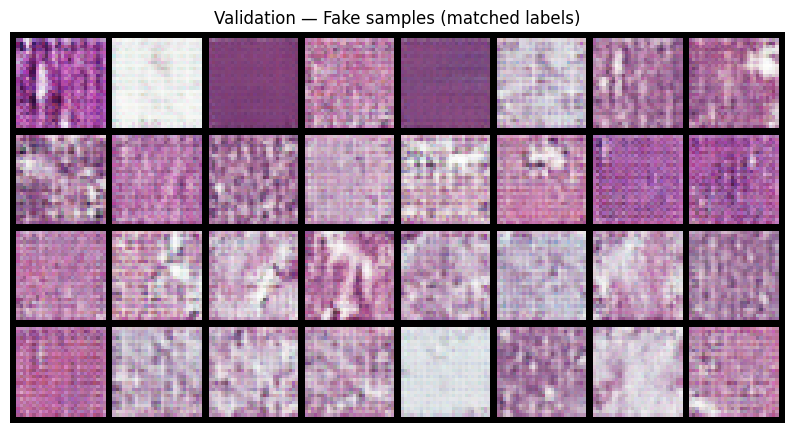


Done. Reminder: synthetic images are for research/education only — not for clinical use.


In [2]:
# Medical Image Generation with Conditional DCGAN (PathMNIST) — PyTorch, End‑to‑End
#
# ⚠️ Educational disclaimer: The images produced here are synthetic and intended strictly for research/teaching.
# They must NOT be used for diagnosis or any clinical decision making.

# --- Setup
!pip install medmnist==3.0.1
import os, math, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm

SEED = 42
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# --- Hyperparameters
DATA_FLAG = 'pathmnist'      # Pathology tiles (RGB, 28x28, 9 classes)
BATCH_SIZE = 128
IMG_SIZE = 28
NC = 3                        # number of image channels
N_CLASSES = 9                 # PathMNIST has 9 classes
NZ = 100                      # latent noise dim
EPOCHS = 10                   # teaching‑friendly training length
LR = 2e-4
BETA1 = 0.5

# --- Data: MedMNIST (PathMNIST)
# If running in Colab/Notebook, ensure medmnist is installed:
# !pip -q install medmnist==3.0.1

import medmnist
from medmnist import INFO
info = INFO[DATA_FLAG]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])  # scale to [-1,1]
])

train_ds = DataClass(split='train', transform=transform, download=True)
val_ds   = DataClass(split='val',   transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- Utilities

def denorm(x):
    return (x.clamp(-1,1) + 1) / 2

def show_grid(tensor, nrow=8, title=None):
    grid = utils.make_grid(denorm(tensor).cpu(), nrow=nrow, padding=2)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

# Create one‑hot vectors and spatial maps (for conditioning)

def one_hot(y, num_classes=N_CLASSES):
    y = y.view(-1).long()
    oh = torch.zeros(y.size(0), num_classes, device=y.device)
    oh[torch.arange(y.size(0)), y] = 1
    return oh

def label_map(y, H=IMG_SIZE, W=IMG_SIZE, num_classes=N_CLASSES):
    # One‑hot planes broadcast spatially: [B, C_classes, H, W]
    oh = one_hot(y, num_classes)
    return oh.view(oh.size(0), oh.size(1), 1, 1).expand(-1, -1, H, W)

# --- Models: Conditional DCGAN (label conditioning)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, nz=NZ, nc=NC, n_classes=N_CLASSES, ngf=64):
        super().__init__()
        self.nz_total = nz + n_classes  # concat noise + onehot label
        self.net = nn.Sequential(
            nn.ConvTranspose2d(self.nz_total, ngf*4, 7, 1, 0, bias=False),   # 1x1 -> 7x7
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),           # 7x7 -> 14x14
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),             # 14x14 -> 28x28
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.Conv2d(ngf, nc, 3, 1, 1),
            nn.Tanh()
        )
    def forward(self, z, y):
        # z: [B, NZ], y: [B] labels
        y_oh = one_hot(y, N_CLASSES)
        zc = torch.cat([z, y_oh], dim=1).unsqueeze(-1).unsqueeze(-1)
        return self.net(zc)

class Discriminator(nn.Module):
    def __init__(self, nc=NC, n_classes=N_CLASSES, ndf=64):
        super().__init__()
        in_ch = nc + n_classes  # image channels + one‑hot planes
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),  # 14x14
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),  # 7x7
            nn.Conv2d(ndf*2, ndf*4, 3, 2, 0, bias=False), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True), # 3x3
            nn.Conv2d(ndf*4, 1, 3, 1, 0, bias=False)  # 1x1 -> logits
        )
    def forward(self, x, y):
        y_map = label_map(y, x.size(2), x.size(3), N_CLASSES)
        x_in = torch.cat([x, y_map], dim=1)
        out = self.net(x_in).view(-1)
        return out

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init); D.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()
optG = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, 0.999))

# Fixed noise/labels for consistent monitoring
fixed_labels = torch.arange(0, N_CLASSES, device=device)
fixed_noise = torch.randn(N_CLASSES, NZ, device=device)

# --- Training
G_losses, D_losses = [], []

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.squeeze().to(device)
        b = imgs.size(0)
        ones  = torch.ones(b, device=device)
        zeros = torch.zeros(b, device=device)

        # --- Train D: maximize log D(x,y) + log(1-D(G(z,y),y))
        D.zero_grad()
        # Real
        logits_real = D(imgs, labels)
        loss_real = criterion(logits_real, ones)
        # Fake
        z = torch.randn(b, NZ, device=device)
        fake = G(z, labels).detach()
        logits_fake = D(fake, labels)
        loss_fake = criterion(logits_fake, zeros)
        loss_D = (loss_real + loss_fake)
        loss_D.backward()
        optD.step()

        # --- Train G: maximize log D(G(z,y),y)
        G.zero_grad()
        z = torch.randn(b, NZ, device=device)
        fake = G(z, labels)
        logits = D(fake, labels)
        loss_G = criterion(logits, ones)
        loss_G.backward()
        optG.step()

        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
        pbar.set_postfix(D=loss_D.item(), G=loss_G.item())

    # Epoch snapshot: class‑conditioned grid
    with torch.no_grad():
        samples = G(fixed_noise, fixed_labels)
    show_grid(samples, nrow=N_CLASSES, title=f'G Samples — epoch {epoch+1}')

# --- Post‑training: Loss curves
plt.figure(figsize=(8,4))
plt.plot(D_losses, label='D')
plt.plot(G_losses, label='G')
plt.xlabel('Iteration'); plt.ylabel('Loss'); plt.legend(); plt.title('Training Loss')
plt.show()

# --- Qualitative evaluation: per‑class sampling
@torch.no_grad()
def generate_per_class(n_per_class=8):
    all_imgs = []
    for c in range(N_CLASSES):
        y = torch.full((n_per_class,), c, device=device)
        z = torch.randn(n_per_class, NZ, device=device)
        imgs = G(z, y)
        all_imgs.append(imgs)
    return torch.cat(all_imgs, dim=0)

samples = generate_per_class(8)
show_grid(samples, nrow=8, title='Per‑class conditional generations (top‑to‑bottom: class 0..8)')

# --- Save checkpoints
os.makedirs('checkpoints', exist_ok=True)
torch.save(G.state_dict(), 'checkpoints/cdcgan_pathmnist_G.pth')
torch.save(D.state_dict(), 'checkpoints/cdcgan_pathmnist_D.pth')
print('Saved checkpoints to ./checkpoints')

# --- Simple real vs fake comparison
# take a batch of real images and show next to generated of same labels
real_batch = next(iter(val_loader))
real_imgs, real_labels = real_batch[0].to(device), real_batch[1].squeeze().to(device)
with torch.no_grad():
    z = torch.randn(real_imgs.size(0), NZ, device=device)
    fake_imgs = G(z, real_labels)

show_grid(real_imgs[:32], nrow=8, title='Validation — Real samples')
show_grid(fake_imgs[:32], nrow=8, title='Validation — Fake samples (matched labels)')

print('\nDone. Reminder: synthetic images are for research/education only — not for clinical use.')
